In [1]:
!pip install numpy==1.23.5
!pip install librosa==0.9.2
!pip install pesq
!pip install pystoi
!pip install soundfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 93.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.3/214.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.5 MB/s eta 0:00:00
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.0
  Preparing metadata (setup.py) ... done
  

In [2]:
# 📦 Import required libraries
import numpy as np
import scipy.signal as signal
import soundfile as sf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import os
from pesq import pesq
from pystoi import stoi
from IPython.display import Audio, display

In [3]:
# 📁 Create output directory
os.makedirs("outputs", exist_ok=True)

In [4]:
# STEP 1: Load clean and noisy speech files from NOIZEUS (for training)
training_files = [
    ("sp01.wav", "sp01_babble_sn5.wav"),
    ("sp03.wav", "sp03_car_sn5.wav"),
    ("sp05.wav", "sp05_exhibition_sn5.wav"),
    ("sp08.wav", "sp08_restaurant_sn5.wav")
]

In [5]:
# STEP 2: Define richer action space (filters + gain) // unit Hz
actions = [
    (300, 2800, 0.8), (350, 2900, 0.9), (400, 3000, 1.0),
    (450, 3100, 1.1), (500, 3200, 1.2), (550, 3300, 1.3),
    (600, 3400, 1.4), (650, 3500, 1.5)
]

In [6]:
# STEP 3: Define multiple states based on audio features
def calculate_state(noisy, clean):
    snr = np.mean(clean ** 2) / (np.mean((noisy - clean) ** 2) + 1e-6)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=noisy))
    centroid = np.mean(librosa.feature.spectral_centroid(y=noisy, sr=16000))

    # Debug info to help you analyze real-time values
    print(f"SNR: {snr:.2f}, ZCR: {zcr:.4f}, Centroid: {centroid:.2f}")

    # More realistic condition-based state logic
    if snr < 1.5 and centroid < 2000:
        return 0                                # Very noisy and low-pitch (e.g., car/babble)
    elif snr < 3 and zcr < 0.07:
        return 1                                # Moderate noise and stable speech
    elif centroid > 3000:
        return 2                                # Sharp / high-frequency noise (e.g., street, hiss)
    else:
        return 3                                # Clean or neutral speech


In [7]:
# STEP 4: Q-learning setup
n_states = 4
n_actions = len(actions)
Q = np.zeros((n_states, n_actions))
alpha = 0.1
gamma = 0.9
epsilon = 0.2
episodes = 100
rewards_history = []

In [8]:
# STEP 5: Q-learning training loop
for ep in range(episodes):
    clean_file, noisy_file = random.choice(training_files)
    clean, _ = librosa.load(clean_file, sr=16000)
    noisy, _ = librosa.load(noisy_file, sr=16000)
    clean = clean[:16000 * 3]
    noisy = noisy[:16000 * 3]

    state = calculate_state(noisy, clean)
    action_index = random.randint(0, n_actions - 1) if random.uniform(0, 1) < epsilon else np.argmax(Q[state])
    low, high, gain = actions[action_index]

    b, a = signal.butter(4, [low / (16000 / 2), high / (16000 / 2)], btype='band')
    filtered = signal.lfilter(b, a, noisy) * gain

    try:
        pesq_score = pesq(16000, clean, filtered, 'wb')
    except:
        pesq_score = 0
    stoi_score = stoi(clean, filtered, 16000, extended=False)
    reward = 0.6 * pesq_score + 0.4 * stoi_score
    rewards_history.append(reward)

    Q[state, action_index] += alpha * (reward + gamma * np.max(Q[state]) - Q[state, action_index])


SNR: 2.78, ZCR: 0.1152, Centroid: 1187.63
SNR: 2.78, ZCR: 0.1152, Centroid: 1187.63
SNR: 2.70, ZCR: 0.1596, Centroid: 1427.41
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.70, ZCR: 0.0957, Centroid: 1108.23
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.70, ZCR: 0.1596, Centroid: 1427.41
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.70, ZCR: 0.1596, Centroid: 1427.41
SNR: 2.70, ZCR: 0.0957, Centroid: 1108.23
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.70, ZCR: 0.1596, Centroid: 1427.41
SNR: 2.78, ZCR: 0.1152, Centroid: 1187.63
SNR: 2.70, ZCR: 0.1596, Centroid: 1427.41
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.78, ZCR: 0.1152, Centroid: 1187.63
SNR: 2.72, ZCR: 0.1094, Centroid: 1237.42
SNR: 2.78, ZCR: 0.1152, Centroid: 1187.63
SNR: 2.70, ZCR: 0.0957, Centroid: 1108.23
SNR: 2.70, ZCR: 0.0957, Centroid: 

In [11]:
# STEP 6: Apply best learned filter to 10 evaluation files
eval_files = [
    ("sp01.wav", "sp01_babble_sn5.wav"),
    ("sp02.wav", "sp02_car_sn5.wav"),
    ("sp03.wav", "sp03_exhibition_sn5.wav"),
    ("sp04.wav", "sp04_restaurant_sn5.wav"),
    ("sp05.wav", "sp05_airport_sn5.wav"),
    ("sp06.wav", "sp06_street_sn5.wav"),
    ("sp07.wav", "sp07_train_sn5.wav"),
    ("sp08.wav", "sp08_babble_sn10.wav"),
    ("sp09.wav", "sp09_car_sn10.wav"),
    ("sp10.wav", "sp10_exhibition_sn10.wav")
]

In [13]:
# STEP 7: Audio playback (for every audio)
for i, (clean_file, noisy_file) in enumerate(eval_files, 1):
    clean, _ = librosa.load(clean_file, sr=16000)
    noisy, _ = librosa.load(noisy_file, sr=16000)
    clean = clean[:16000 * 3]
    noisy = noisy[:16000 * 3]
    state = calculate_state(noisy, clean)
    best_idx = np.argmax(Q[state])
    low, high, gain = actions[best_idx]
    b, a = signal.butter(4, [low / (16000 / 2), high / (16000 / 2)], btype='band')
    filtered = signal.lfilter(b, a, noisy) * gain
    sf.write(f"outputs/filtered_output_{i}.wav", filtered, 16000)
    print(f"\n🎧 Part {i}: {noisy_file} | State: {state} | Filter: {low}-{high} Hz | Gain: {gain}")
    display(Audio(clean, rate=16000))
    display(Audio(noisy, rate=16000))
    display(Audio(filtered, rate=16000))

SNR: 2.70, ZCR: 0.0957, Centroid: 1108.23

🎧 Part 1: sp01_babble_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 2.71, ZCR: 0.1147, Centroid: 1225.04

🎧 Part 2: sp02_car_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 2.78, ZCR: 0.1545, Centroid: 1403.03

🎧 Part 3: sp03_exhibition_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 2.84, ZCR: 0.1136, Centroid: 1189.75

🎧 Part 4: sp04_restaurant_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 2.70, ZCR: 0.1093, Centroid: 1159.36

🎧 Part 5: sp05_airport_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 2.66, ZCR: 0.1600, Centroid: 1423.87

🎧 Part 6: sp06_street_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 2.84, ZCR: 0.1660, Centroid: 1484.53

🎧 Part 7: sp07_train_sn5.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 8.58, ZCR: 0.1078, Centroid: 1224.21

🎧 Part 8: sp08_babble_sn10.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 9.18, ZCR: 0.1228, Centroid: 1295.14

🎧 Part 9: sp09_car_sn10.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


SNR: 8.55, ZCR: 0.1472, Centroid: 1378.71

🎧 Part 10: sp10_exhibition_sn10.wav | State: 3 | Filter: 300-2800 Hz | Gain: 0.8


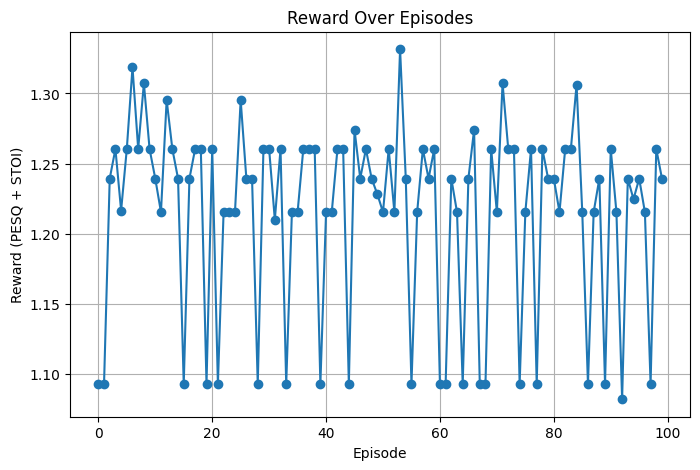

In [14]:
# STEP 8: Plot reward trend
plt.figure(figsize=(8, 5))
plt.plot(rewards_history, marker='o')
plt.title("Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward (PESQ + STOI)")
plt.grid(True)
plt.savefig("outputs/reward_plot.png")
plt.show()


In [16]:
# STEP 9: Display Q-table
print("\n📊 Final Q-Table:")
for s in range(n_states):
    print(f"State {s}: {Q[s]}")


📊 Final Q-Table:
State 0: [0. 0. 0. 0. 0. 0. 0. 0.]
State 1: [0. 0. 0. 0. 0. 0. 0. 0.]
State 2: [0. 0. 0. 0. 0. 0. 0. 0.]
State 3: [6.98298662 1.03372594 0.53805126 1.23330357 1.36425096 0.6775529
 0.53740554 0.695828  ]


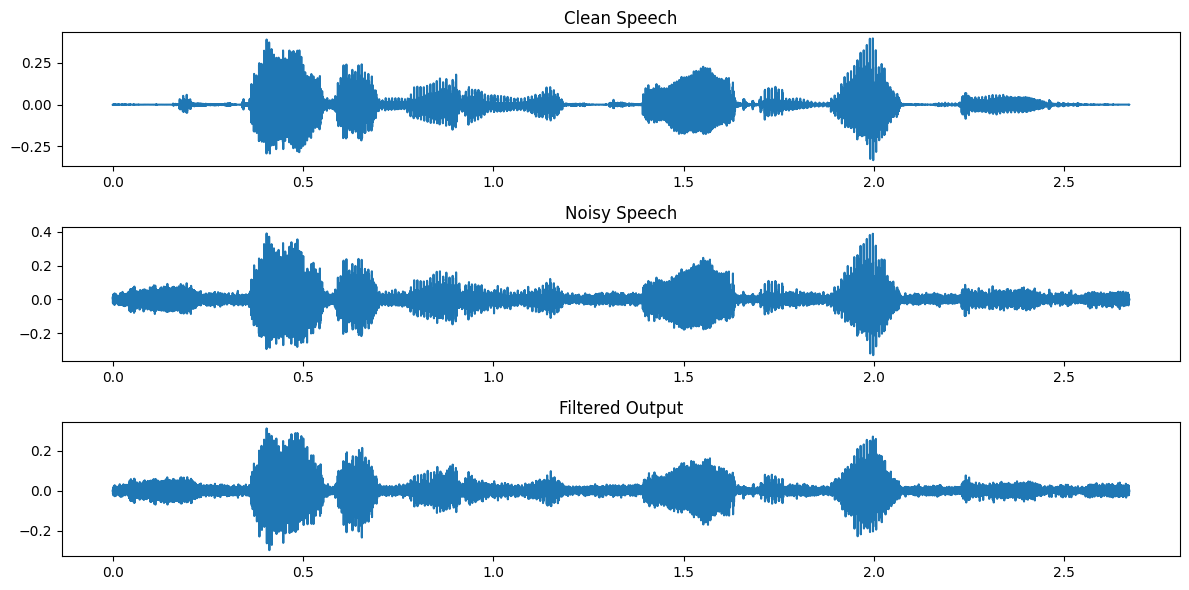

In [17]:
# STEP 10: Waveform plots (for the last eval file)
time = np.linspace(0, len(clean) / 16000, len(clean))
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(time, clean)
plt.title("Clean Speech")
plt.subplot(3, 1, 2)
plt.plot(time, noisy)
plt.title("Noisy Speech")
plt.subplot(3, 1, 3)
plt.plot(time, filtered)
plt.title("Filtered Output")
plt.tight_layout()
plt.savefig("outputs/waveform_comparison.png")
plt.show()

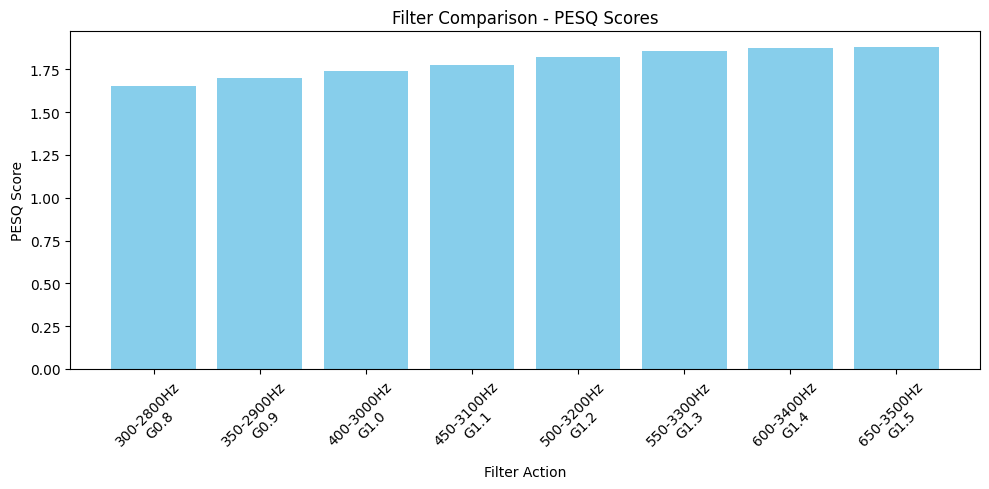

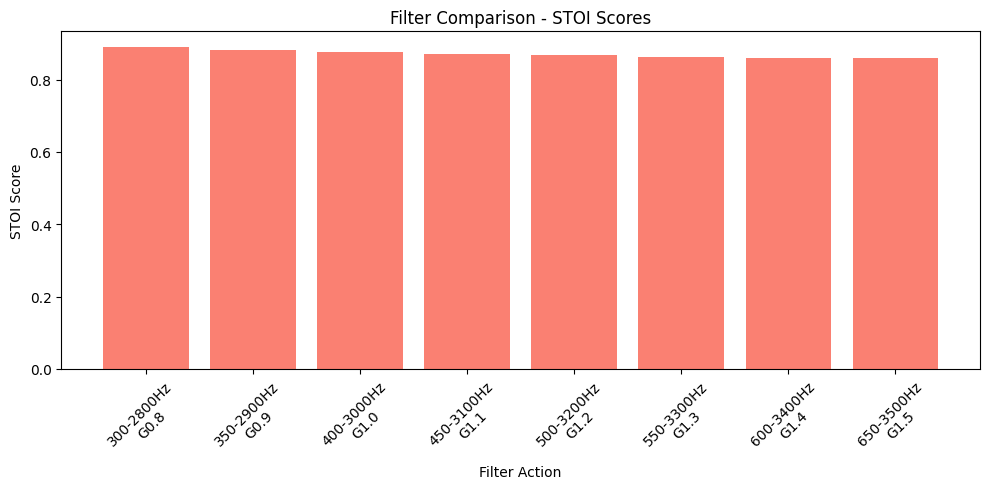

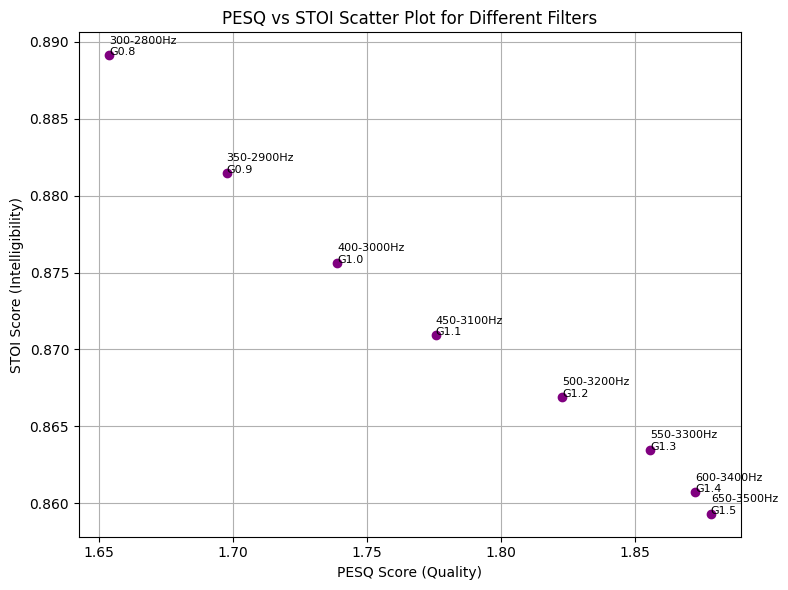

In [18]:
# STEP 11: Compare All Filters - PESQ & STOI Scores
pesq_vals = []
stoi_vals = []
labels = []

# Loop through all filter actions
for (low, high, gain) in actions:
    b, a = signal.butter(4, [low / (16000 / 2), high / (16000 / 2)], btype='band')
    test_filtered = signal.lfilter(b, a, noisy) * gain

    try:
        p = pesq(16000, clean, test_filtered, 'wb')
    except:
        p = 0
    s = stoi(clean, test_filtered, 16000, extended=False)

    pesq_vals.append(p)
    stoi_vals.append(s)
    labels.append(f"{low}-{high}Hz\nG{gain:.1f}")

x = np.arange(len(actions))

# Plot PESQ separately
plt.figure(figsize=(10, 5))
plt.bar(x, pesq_vals, color='skyblue')
plt.xticks(x, labels, rotation=45)
plt.title("Filter Comparison - PESQ Scores")
plt.xlabel("Filter Action")
plt.ylabel("PESQ Score")
plt.tight_layout()
plt.savefig("outputs/pesq_comparison.png")
plt.show()

# Plot STOI separately
plt.figure(figsize=(10, 5))
plt.bar(x, stoi_vals, color='salmon')
plt.xticks(x, labels, rotation=45)
plt.title("Filter Comparison - STOI Scores")
plt.xlabel("Filter Action")
plt.ylabel("STOI Score")
plt.tight_layout()
plt.savefig("outputs/stoi_comparison.png")
plt.show()

# Optional: Scatter plot to visualize PESQ vs STOI relation
plt.figure(figsize=(8,6))
plt.scatter(pesq_vals, stoi_vals, c='purple')
for i, label in enumerate(labels):
    plt.annotate(label, (pesq_vals[i], stoi_vals[i]), fontsize=8)
plt.title("PESQ vs STOI Scatter Plot for Different Filters")
plt.xlabel("PESQ Score (Quality)")
plt.ylabel("STOI Score (Intelligibility)")
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/pesq_vs_stoi_scatter.png")
plt.show()
